# Predicting Steam Recommendation

## Introduction to Problem & Data

#### Problem Statement:

Steam has established itself as one of the most prominent digital distribution platforms for PC gaming, hosting thousands of titles and attracting millions of users worldwide. For my final project, I aim to develop a predictive model capable of determining whether a user will recommend a game based on a combination of game features and user behavior. The recommendation status, represented as a binary outcome (is_recommended), serves as a valuable indicator of a game’s quality, popularity, and user satisfaction.

This model may be particularly useful for game developers, publishers, and platform managers seeking to identify the key factors that drive positive recommendations. By understanding which attributes—such as price, playtime, discounts, and reviews—most influence user satisfaction, stakeholders can make data-driven decisions to improve user engagement, optimize pricing strategies, and prioritize game features that resonate with their audience.

The successful development of this model will not only enhance the ability to predict user recommendations but will also provide actionable insights for stakeholders in the gaming industry. Game developers can align their design choices with player preferences, marketing teams can target the most engaged users effectively, and the Steam platform can improve its game discovery algorithms to maximize user satisfaction. Furthermore, analyzing trends in user behavior and game popularity will offer a deeper understanding of how the gaming landscape has evolved over time, contributing to strategic planning and decision-making in this dynamic and competitive industry.

In [1]:
import pandas as pd
import numpy as np

games = pd.read_csv('data/games.csv')
users = pd.read_csv('data/users.csv')
recommendations = pd.read_csv('data/recommendations.csv')

In [2]:
print("Games:\n", games.head(), "\n")
print("Users:\n", users.head(), "\n")
print("Recommendations:\n", recommendations.head(), "\n")

Games:
    app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   discount  steam_deck  
0   

In [6]:
print(games.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB
None


In [7]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB
None


In [8]:
print(recommendations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB
None


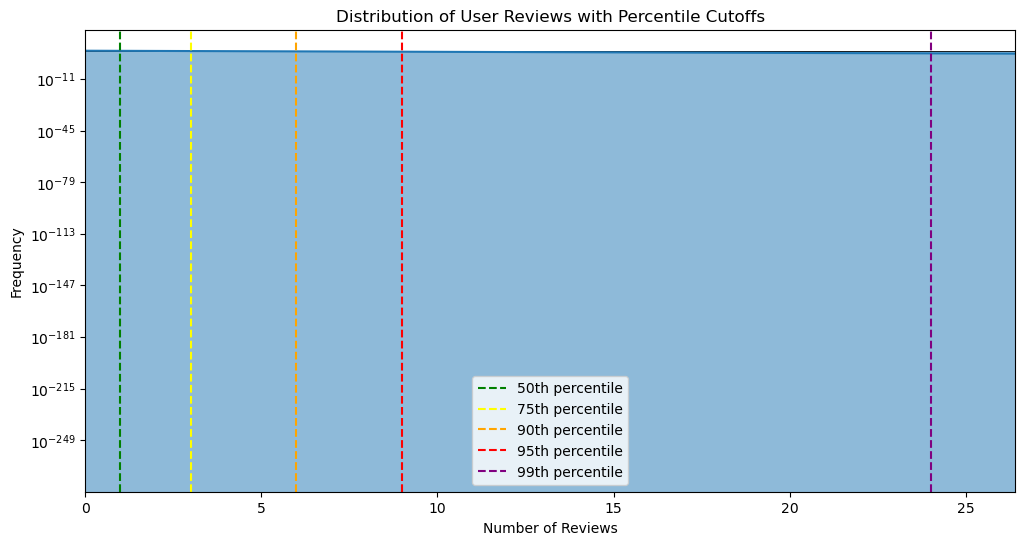

Percentile cutoffs:
50th percentile: 1.0 reviews
75th percentile: 3.0 reviews
90th percentile: 6.0 reviews
95th percentile: 9.0 reviews
99th percentile: 24.0 reviews


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

percentiles = users['reviews'].quantile([0.5, 0.75, 0.90, 0.95, 0.99])

plt.figure(figsize=(12, 6))
sns.histplot(data=users, x='reviews', bins=100, kde=True)

colors = ['green', 'yellow', 'orange', 'red', 'purple']
labels = ['50th', '75th', '90th', '95th', '99th']
for (p, c, l) in zip(percentiles, colors, labels):
    plt.axvline(x=p, color=c, linestyle='--', label=f'{l} percentile')

plt.title('Distribution of User Reviews with Percentile Cutoffs')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.legend()

plt.xlim(0, percentiles[0.99] * 1.1)

plt.yscale('log')

plt.show()

print("Percentile cutoffs:")
for p, v in percentiles.items():
    print(f"{int(p*100)}th percentile: {v:.1f} reviews")


Helpfulness Statistics:
count    4.115479e+07
mean     3.202567e+00
std      4.693649e+01
min      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
90%      4.000000e+00
95%      8.000000e+00
99%      4.900000e+01
max      3.621200e+04
Name: helpful, dtype: float64


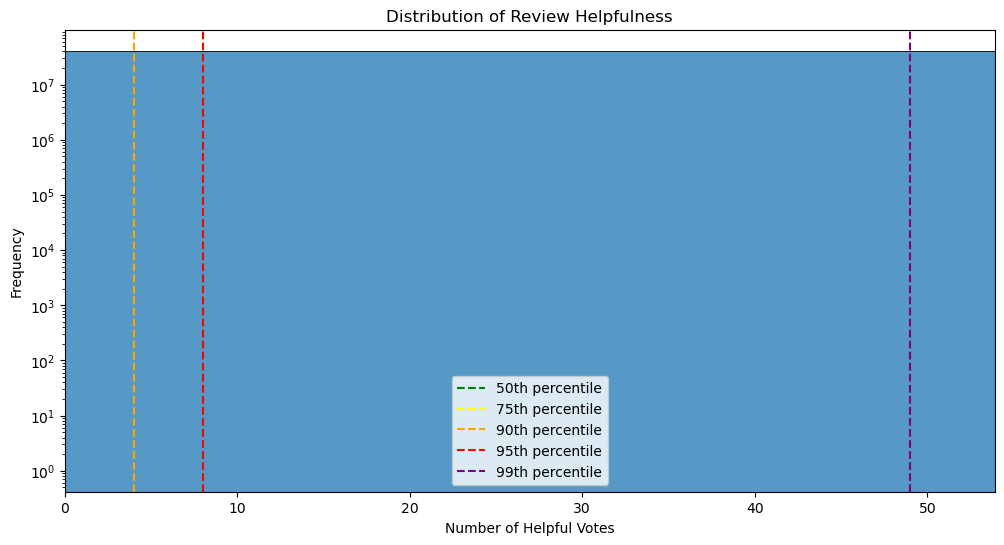


Suggested helpfulness thresholds:
Minimum (50th percentile): 0 helpful votes
Medium (75th percentile): 0 helpful votes
High (90th percentile): 4 helpful votes
Very high (95th percentile): 8 helpful votes
Exceptional (99th percentile): 49 helpful votes


In [18]:
# Analyze helpfulness distribution
helpfulness_stats = recommendations['helpful'].describe(percentiles=[.5, .75, .90, .95, .99])
print("\nHelpfulness Statistics:")
print(helpfulness_stats)

plt.figure(figsize=(12, 6))
sns.histplot(data=recommendations, x='helpful', bins=100)
plt.title('Distribution of Review Helpfulness')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Frequency')

percentiles = recommendations['helpful'].quantile([0.5, 0.75, 0.90, 0.95, 0.99])
colors = ['green', 'yellow', 'orange', 'red', 'purple']
labels = ['50th', '75th', '90th', '95th', '99th']

for (p, c, l) in zip(percentiles, colors, labels):
    plt.axvline(x=p, color=c, linestyle='--', label=f'{l} percentile')

plt.legend()
plt.yscale('log')  
plt.xlim(0, percentiles.iloc[-1] * 1.1)  
plt.show()

print("\nSuggested helpfulness thresholds:")
print(f"Minimum (50th percentile): {percentiles[0.50]:.0f} helpful votes")
print(f"Medium (75th percentile): {percentiles[0.75]:.0f} helpful votes")
print(f"High (90th percentile): {percentiles[0.90]:.0f} helpful votes")
print(f"Very high (95th percentile): {percentiles[0.95]:.0f} helpful votes")
print(f"Exceptional (99th percentile): {percentiles[0.99]:.0f} helpful votes")

Instead of processing the entire dataset, we select a small, representative portion of the data for all subsequent operations.


In [19]:
# Select the top 200 most-reviewed games
selected_games = games.sort_values('user_reviews', ascending=False).head(200)

selected_games.to_csv('data/selected_games.csv', index=False)
print(f"Selected Games: {selected_games.shape}")



Selected Games: (200, 13)


In [43]:
# Determine Active Users Threshold (99th percentile)
active_threshold = users['reviews'].quantile(0.99)
print(f"Active Users Threshold (99th percentile): {active_threshold} reviews")

# Select active users based on the threshold
active_users = users[users['reviews'] >= active_threshold]
active_users.to_csv('data/active_users.csv', index=False)
print(f"Number of Active Users: {active_users.shape[0]}")

Active Users Threshold (99th percentile): 24.0 reviews
Number of Active Users: 153999


In [44]:
# Filter recommendations with helpful threshold
filtered_recommendations = recommendations[
    (recommendations['app_id'].isin(selected_games['app_id'])) &
    (recommendations['user_id'].isin(active_users['user_id'])) &
    (recommendations['helpful'] >= 4)  # 90th percentile threshold
]
filtered_recommendations.to_csv('data/filtered_recommendations.csv', index=False)
print(f"Recommendations after helpfulness filtering: {filtered_recommendations.shape}")

Recommendations after helpfulness filtering: (236303, 8)


In [46]:
from sklearn.model_selection import train_test_split

# Stratified sampling to maintain class balance
sampled_recommendations = filtered_recommendations.groupby('is_recommended', group_keys=False).apply(
    lambda x: x.sample(frac=0.15, random_state=42)
)
sampled_recommendations.to_csv('data/sampled_recommendations.csv', index=False)
print(f"Sampled Recommendations: {sampled_recommendations.shape}")

Sampled Recommendations: (35445, 8)


In [47]:
# Merge game attributes
final_dataset = sampled_recommendations.merge(
    selected_games[['app_id', 'price_final', 'discount', 'positive_ratio', 'date_release', 'rating']],
    on='app_id',
    how='left'
)
final_dataset.to_csv('data/final_dataset.csv', index=False)

print(f"Final Dataset Size after Merge: {final_dataset.shape}")

Final Dataset Size after Merge: (35445, 13)


In [48]:
print(final_dataset.columns)

Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id', 'price_final', 'discount', 'positive_ratio',
       'date_release', 'rating'],
      dtype='object')


In [49]:
# Convert 'date_release' to datetime
final_dataset['date_release'] = pd.to_datetime(final_dataset['date_release'], errors='coerce')


In [50]:
# Extract additional temporal features
final_dataset['release_year'] = final_dataset['date_release'].dt.year
final_dataset['release_month'] = final_dataset['date_release'].dt.month
final_dataset['time_since_release'] = 2024 - final_dataset['release_year']  


In [51]:
# Encode 'rating' as categorical variables using one-hot encoding
final_dataset = pd.get_dummies(final_dataset, columns=['rating'], drop_first=True)

print("Columns after encoding:", final_dataset.columns)

Columns after encoding: Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id', 'price_final', 'discount', 'positive_ratio',
       'date_release', 'release_year', 'release_month', 'time_since_release',
       'rating_Mostly Negative', 'rating_Mostly Positive',
       'rating_Overwhelmingly Positive', 'rating_Very Positive'],
      dtype='object')


The revised dataset that I will be working with contains detailed information on 500 of the most-reviewed games available on the Steam platform. These games, released between 1998 and 2023, span a wide range of genres, platforms, and pricing models.

## Exploratory Data Analysis

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', color_codes=True)
plt.rcParams['figure.figsize'] = (12, 8)

In [53]:
# Load the optimized dataset
final_dataset = pd.read_csv('data/final_dataset.csv', parse_dates=['date_release'])
print("Final Dataset Loaded. Shape:", final_dataset.shape)
final_dataset.head()

Final Dataset Loaded. Shape: (35445, 13)


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,price_final,discount,positive_ratio,date_release,rating
0,221100,7,0,2017-04-17,False,0.3,8088013,16122366,45.0,0.0,74,2018-12-13,Mostly Positive
1,601150,65,9,2019-03-08,False,7.7,10613654,33478462,30.0,0.0,95,2019-03-07,Overwhelmingly Positive
2,8870,7,2,2020-08-24,False,19.4,2289902,25669626,30.0,0.0,93,2013-03-25,Very Positive
3,221100,11,2,2016-01-23,False,0.6,13028588,33538746,45.0,0.0,74,2018-12-13,Mostly Positive
4,306130,4,2,2016-11-22,False,0.7,11834711,5349334,20.0,0.0,83,2017-05-22,Very Positive


In [54]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35445 entries, 0 to 35444
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          35445 non-null  int64         
 1   helpful         35445 non-null  int64         
 2   funny           35445 non-null  int64         
 3   date            35445 non-null  object        
 4   is_recommended  35445 non-null  bool          
 5   hours           35445 non-null  float64       
 6   user_id         35445 non-null  int64         
 7   review_id       35445 non-null  int64         
 8   price_final     35445 non-null  float64       
 9   discount        35445 non-null  float64       
 10  positive_ratio  35445 non-null  int64         
 11  date_release    35445 non-null  datetime64[ns]
 12  rating          35445 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 3.3+ MB


In [55]:
final_dataset.describe()

,app_id,helpful,funny,hours,user_id,review_id,price_final,discount,positive_ratio
count,3.544500e+04,35445.000000,35445.000000,35445.000000,3.544500e+04,3.544500e+04,35445.000000,35445.000000,35445.000000
mean,4.643475e+05,39.729158,13.746875,129.919667,7.795653e+06,1.709235e+07,22.582596,1.922697,88.874058
std,3.922185e+05,183.535753,114.708725,195.085479,3.721284e+06,1.030377e+07,17.816623,12.489549,9.608972
min,1.000000e+01,4.000000,0.000000,0.000000,1.239000e+03,4.220000e+02,0.000000,0.000000,26.000000
25%,2.304100e+05,5.000000,0.000000,14.300000,5.122339e+06,7.507581e+06,9.990000,0.000000,86.000000
50%,3.595500e+05,9.000000,0.000000,46.300000,7.809374e+06,1.887771e+07,20.000000,0.000000,91.000000
75%,5.821600e+05,23.000000,4.000000,149.500000,1.122823e+07,2.420420e+07,30.000000,0.000000,96.000000
max,1.938090e+06,9340.000000,10272.000000,1000.000000,1.430579e+07,4.113536e+07,70.000000,90.000000,98.000000


#### Descriptive Statistics

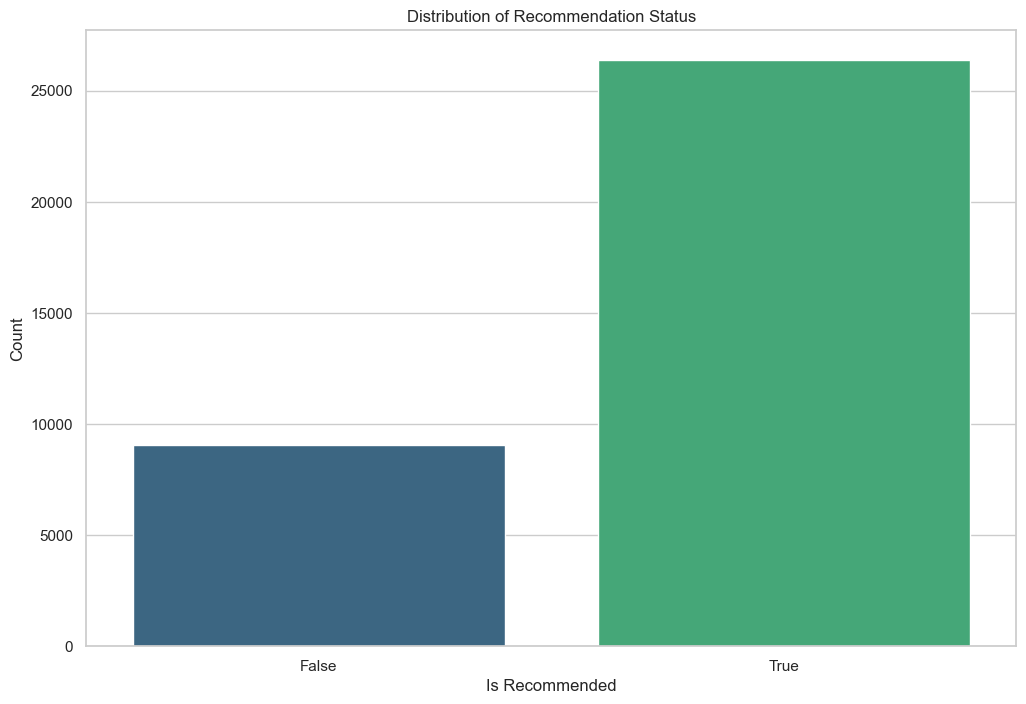

In [56]:
# Distribution of the target variable
sns.countplot(x='is_recommended', data=final_dataset, palette='viridis')
plt.title('Distribution of Recommendation Status')
plt.xlabel('Is Recommended')
plt.ylabel('Count')
plt.show()


In [57]:
# Percentage distribution
recommendation_counts = final_dataset['is_recommended'].value_counts(normalize=True) * 100
print("Recommendation Percentage:")
print(recommendation_counts)

Recommendation Percentage:
True     74.504161
False    25.495839
Name: is_recommended, dtype: float64


Most users are inclined to recommend the games they play

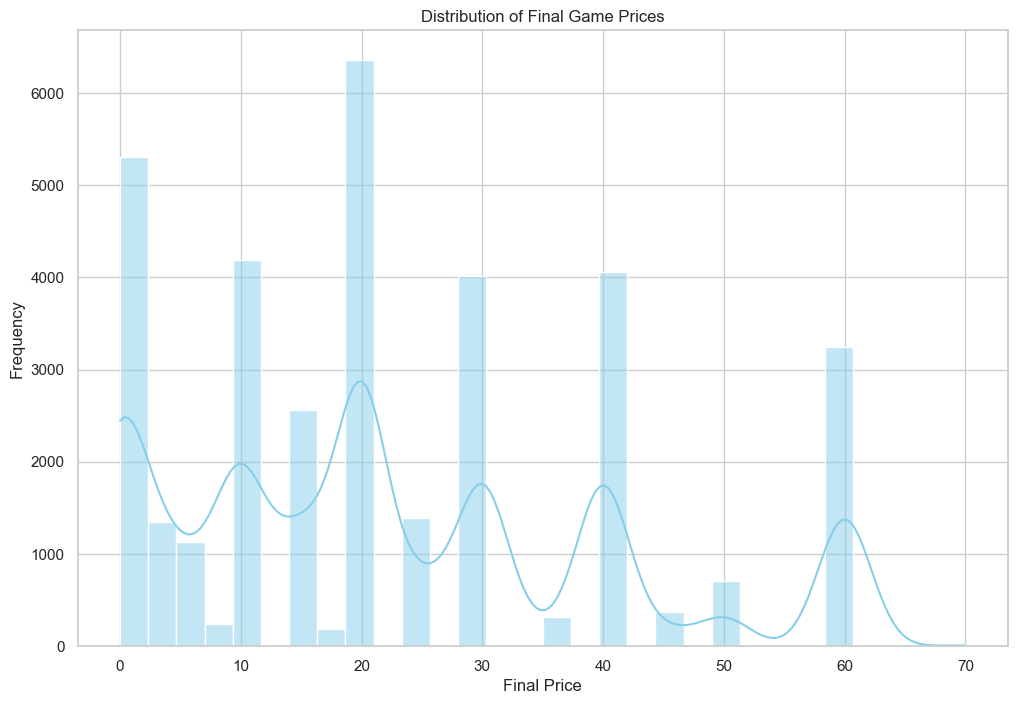

In [58]:
# Histogram of final price
sns.histplot(final_dataset['price_final'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Final Game Prices')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

The highest frequency occurs at $20 (~6,000 counts), reflecting the prevalence of cheap games. Second highest is free game.

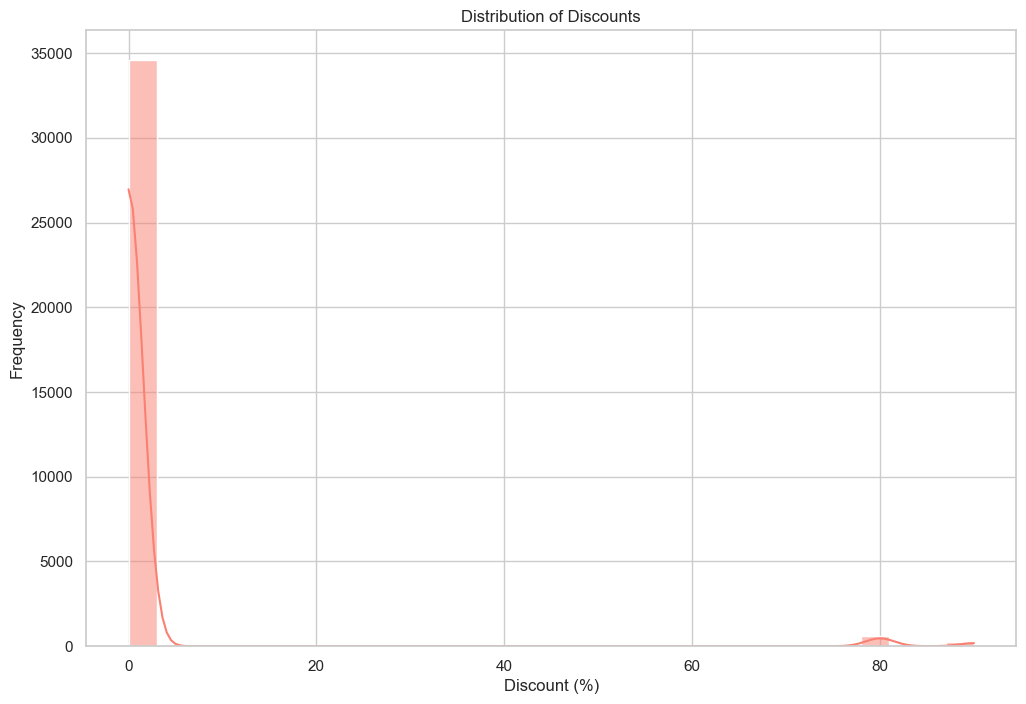

In [59]:
# Histogram of discounts
sns.histplot(final_dataset['discount'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Discounts')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.show()

The distribution of game discounts reveals that the majority of games receive no discount (0%), reflecting a strategy to maintain their base price. Only a small subset of games features discounts, with sporadic occurrences beyond the 20% mark. A slight increase is observed near 80%, likely tied to promotional events or heavy price cuts during sales. This pattern highlights that deep discounts are uncommon for top-reviewed games, as developers likely aim to preserve the perceived value of their titles.

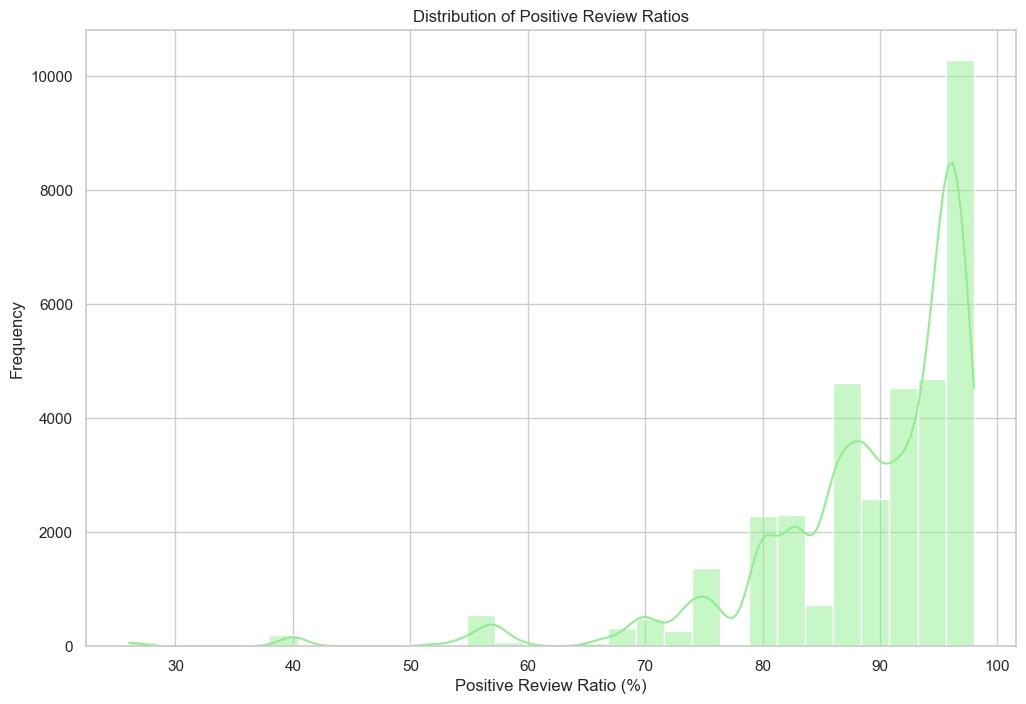

In [60]:
# Histogram of positive review ratios
sns.histplot(final_dataset['positive_ratio'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Positive Review Ratios')
plt.xlabel('Positive Review Ratio (%)')
plt.ylabel('Frequency')
plt.show()

The positive ratio distribution is skewed heavily toward higher values, with the majority of games achieving ratings above 80%. A notable concentration occurs between 90% and 95%, demonstrating that top-reviewed games are generally well-received. This trend reinforces the notion that top-reviewed games consistently meet or exceed player expectations, reflecting their strong quality and widespread appeal on the Steam platform.

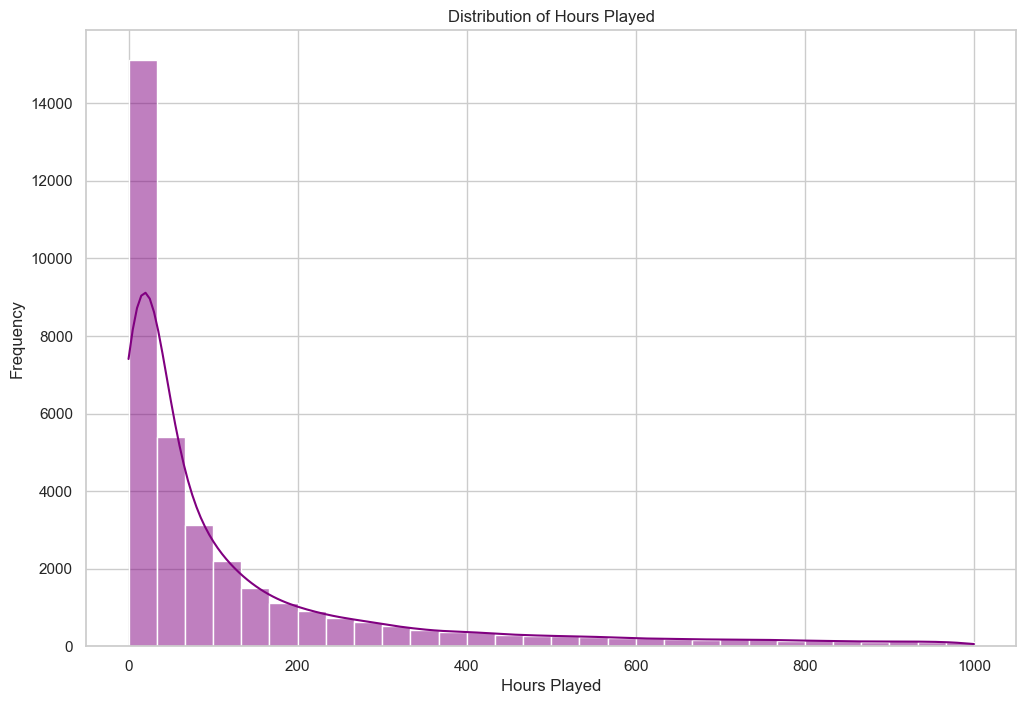

In [61]:
# Histogram of hours played
sns.histplot(final_dataset['hours'], bins=30, kde=True, color='purple')
plt.title('Distribution of Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()

The distribution of hours played is highly skewed, with the majority of users playing for fewer than 50 hours. Playtime frequency decreases sharply as hours increase, but a small subset of users shows extreme engagement, with playtimes exceeding 200 hours and a few approaching 1,000 hours. This indicates that while most players interact with games for a moderate duration, a dedicated minority invests substantial time, reflecting a range of player engagement levels.

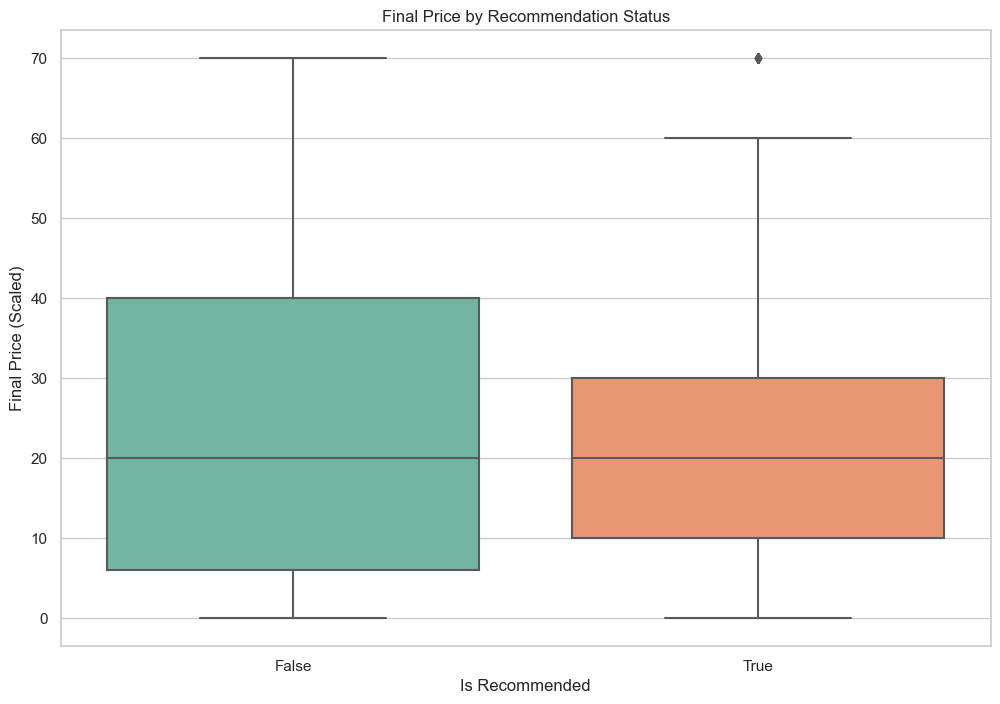

In [63]:
# Box plot of price_final by recommendation status
sns.boxplot(x='is_recommended', y='price_final', data=final_dataset, palette='Set2')
plt.title('Final Price by Recommendation Status')
plt.xlabel('Is Recommended')
plt.ylabel('Final Price (Scaled)')
plt.show()

The boxplot demonstrates that both recommended and non-recommended games are priced similarly, ranging from $0 to $70. The narrower interquartile range for recommended games indicates a more consistent pricing pattern than not-recommended ones.

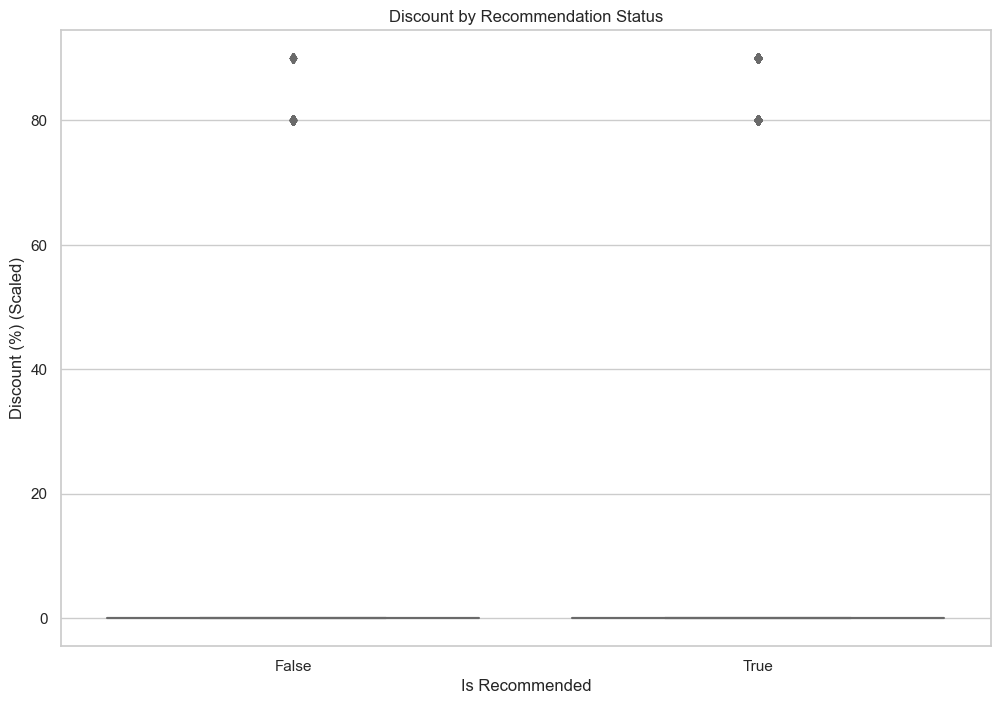

In [64]:
# Box plot of discount by recommendation status
sns.boxplot(x='is_recommended', y='discount', data=final_dataset, palette='Set3')
plt.title('Discount by Recommendation Status')
plt.xlabel('Is Recommended')
plt.ylabel('Discount (%) (Scaled)')
plt.show()

This boxplot reveals that discounts are predominantly clustered near 0% for both recommended and non-recommended games, with only a few outliers showing higher discounts of up to 80%. This suggests that discounts are not a major factor influencing recommendations, as most games maintain their standard pricing.

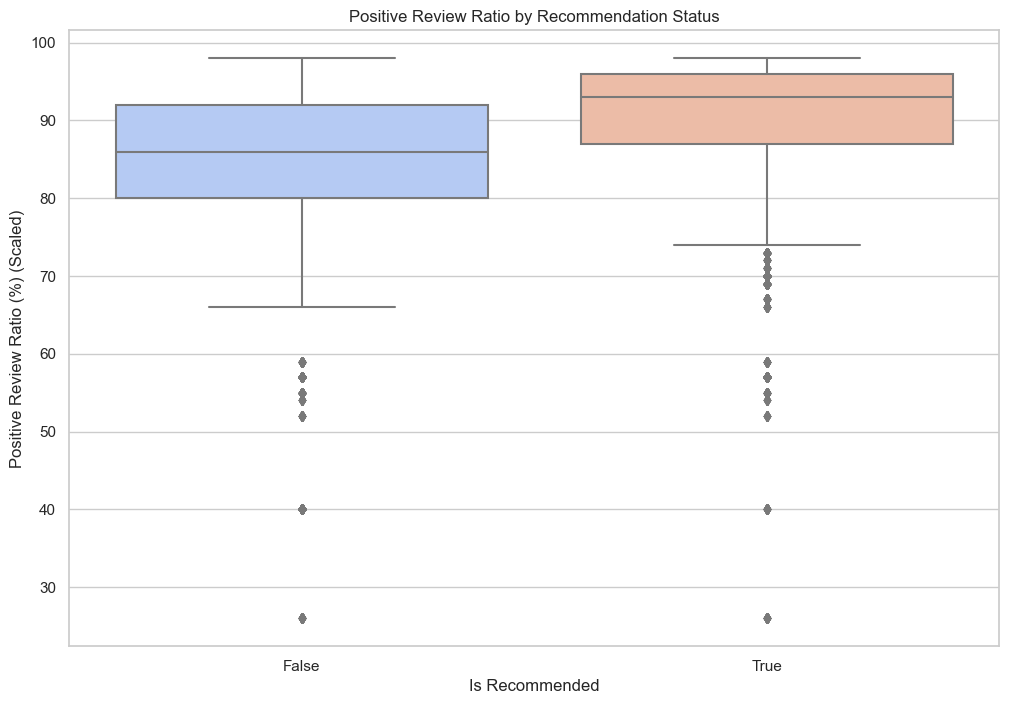

In [65]:
# Box plot of positive_ratio by recommendation status
sns.boxplot(x='is_recommended', y='positive_ratio', data=final_dataset, palette='coolwarm')
plt.title('Positive Review Ratio by Recommendation Status')
plt.xlabel('Is Recommended')
plt.ylabel('Positive Review Ratio (%) (Scaled)')
plt.show()

The boxplot highlights a clear distinction between recommended and non-recommended games. Recommended games have a higher median positive review ratio, with a tighter range between 85% and 95%. Non-recommended games show a wider spread, with some outliers as low as 30%. This indicates that positive feedback plays a significant role in driving recommendations.


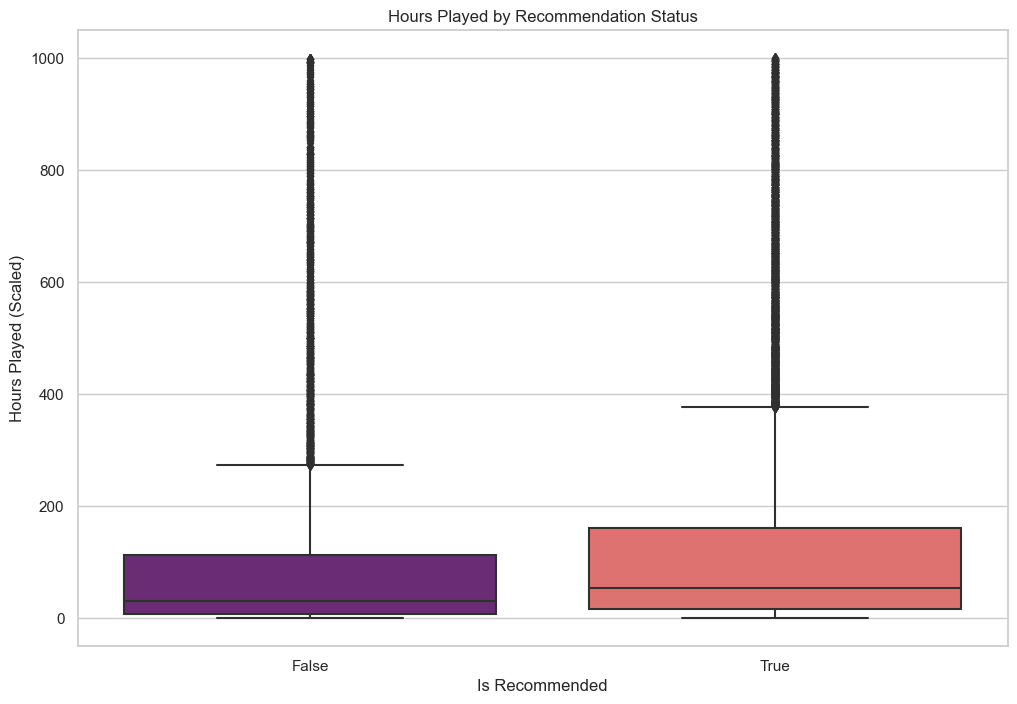

In [66]:
# Box plot of hours played by recommendation status
sns.boxplot(x='is_recommended', y='hours', data=final_dataset, palette='magma')
plt.title('Hours Played by Recommendation Status')
plt.xlabel('Is Recommended')
plt.ylabel('Hours Played (Scaled)')
plt.show()

The boxplot for hours played shows that recommended games have a higher median and a broader interquartile range compared to non-recommended games. Both categories have extensive outliers reaching up to 1,000 hours, indicating that while most users engage minimally, some invest significant playtime, which correlates with higher recommendation rates.


Unique Ratings: ['Mostly Positive' 'Overwhelmingly Positive' 'Very Positive' 'Mixed'
 'Mostly Negative']


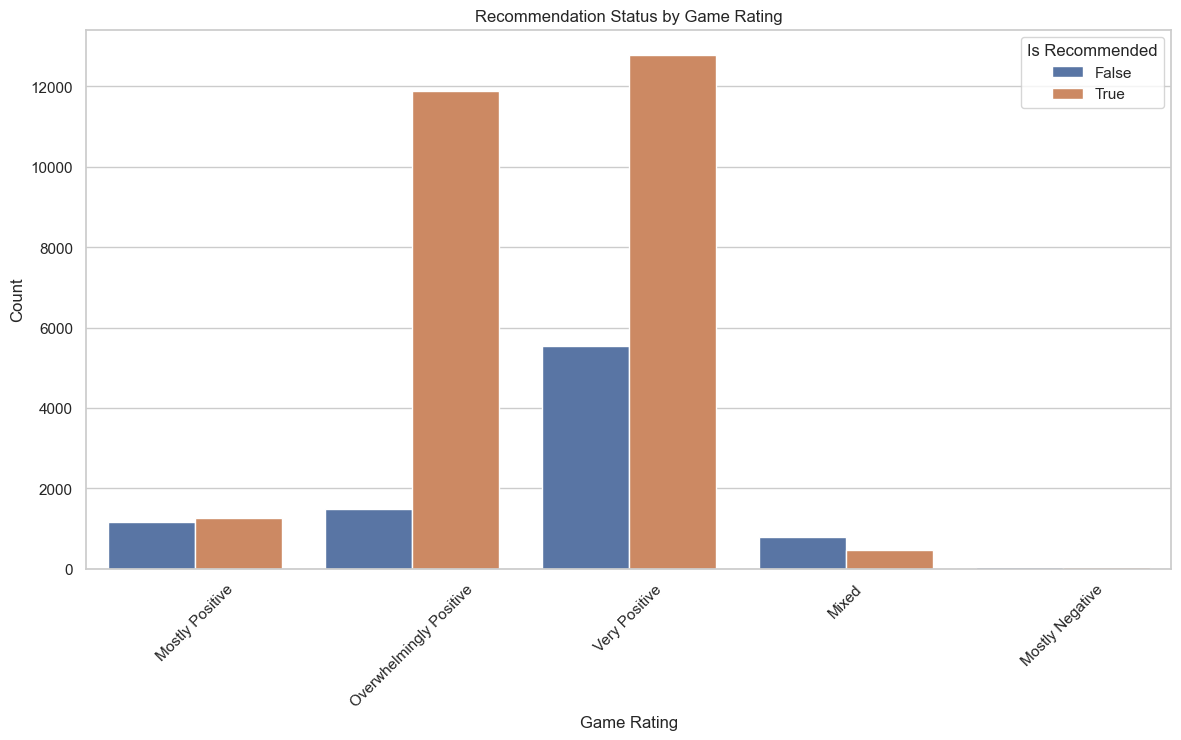

In [80]:
# Check unique ratings
print("\nUnique Ratings:", final_dataset['rating'].unique())

# Count plot of ratings by recommendation status
plt.figure(figsize=(14, 7))
sns.countplot(x='rating', hue='is_recommended', data=final_dataset, palette='deep')
plt.title('Recommendation Status by Game Rating')
plt.xlabel('Game Rating')
plt.ylabel('Count')
plt.legend(title='Is Recommended')
plt.xticks(rotation=45)
plt.show()

The grouped bar chart reveals a strong relationship between higher ratings and recommendation likelihood. Games rated “Very Positive” and “Overwhelmingly Positive” receive the most recommendations. Interestingly, even lower-rated games, such as those with “Mostly Negative” ratings, retain a notable number of endorsements, highlighting varied user preferences.

/var/folders/8z/p8j8677j3q1c2k72t9f_r0h80000gn/T/ipykernel_50421/2336220373.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_dataset.corr()


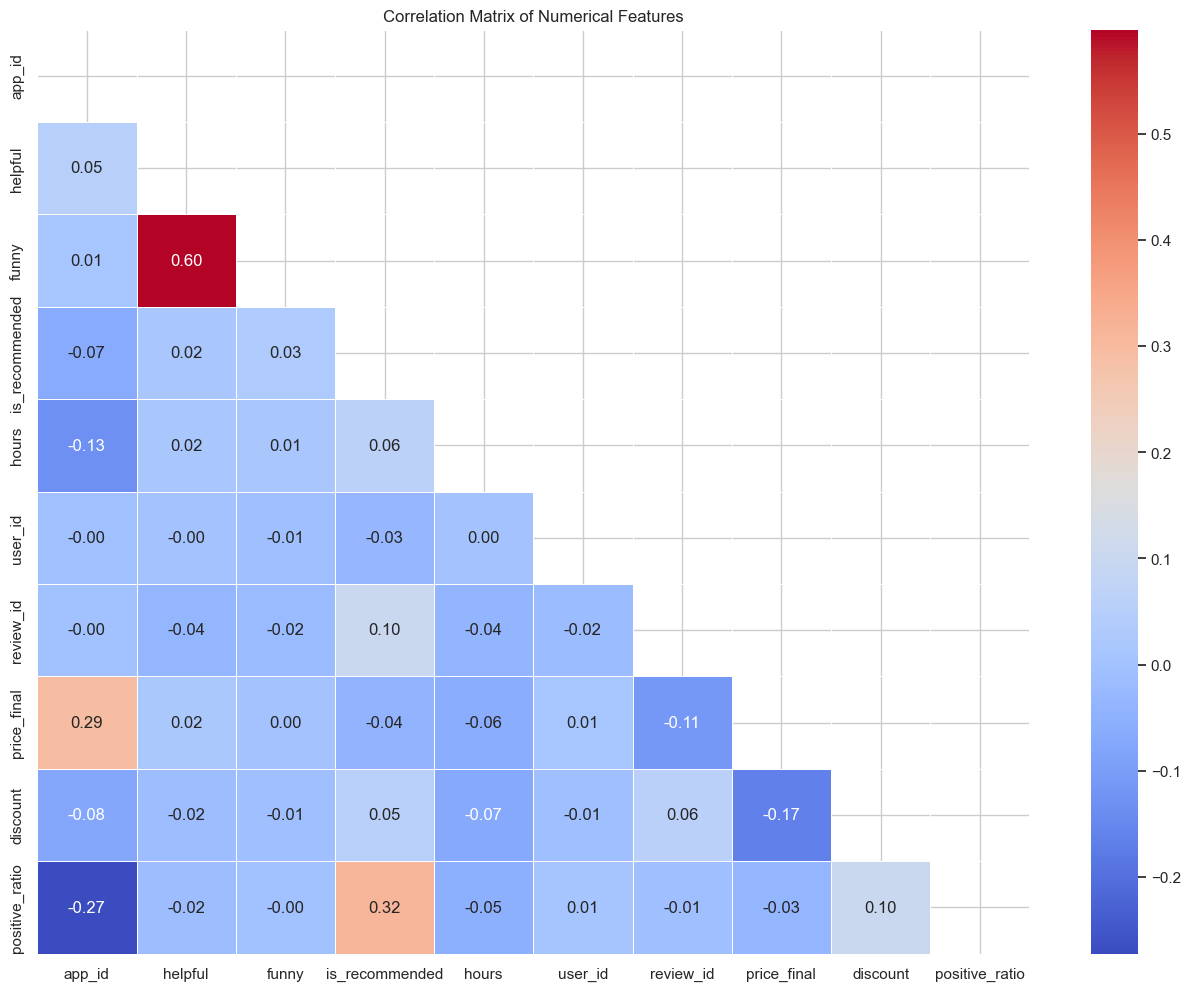

In [81]:
# correlation matrix
corr_matrix = final_dataset.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))

# heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation heatmap highlights a strong positive relationship (0.60) between “helpful” and “funny” metrics, suggesting that reviews perceived as helpful often exhibit humor. A moderate correlation (0.32) exists between “is_recommended” and “positive_ratio,” indicating that games with higher positive reviews are more likely to be recommended. The relatively weak correlations among most other variables suggest limited interdependence, reducing multicollinearity concerns for modeling.

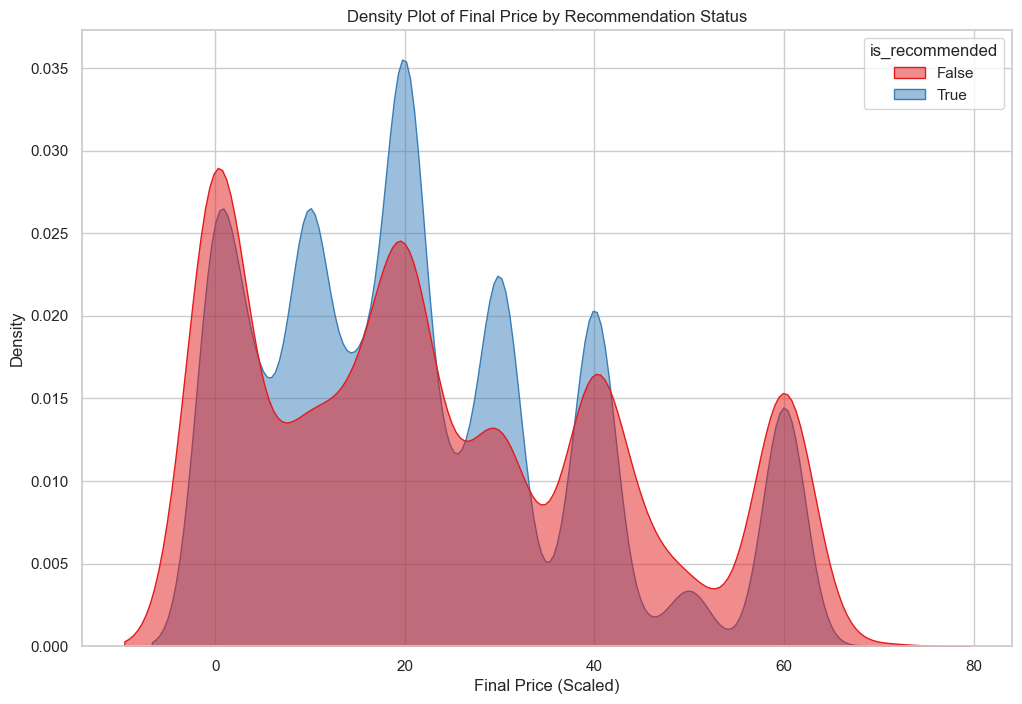

In [82]:
# Density plot of price_final by recommendation status
sns.kdeplot(data=final_dataset, x='price_final', hue='is_recommended', fill=True, common_norm=False, palette='Set1', alpha=0.5)
plt.title('Density Plot of Final Price by Recommendation Status')
plt.xlabel('Final Price (Scaled)')
plt.ylabel('Density')
plt.show()

The density plot for final game prices reveals overlapping multimodal distributions for recommended and non-recommended games. Both categories peak at $0, $20, $40, and $60, with a stronger emphasis on $20 for recommended games. This indicates that moderately priced games may have a higher likelihood of recommendation, although price alone is not a definitive determinant.

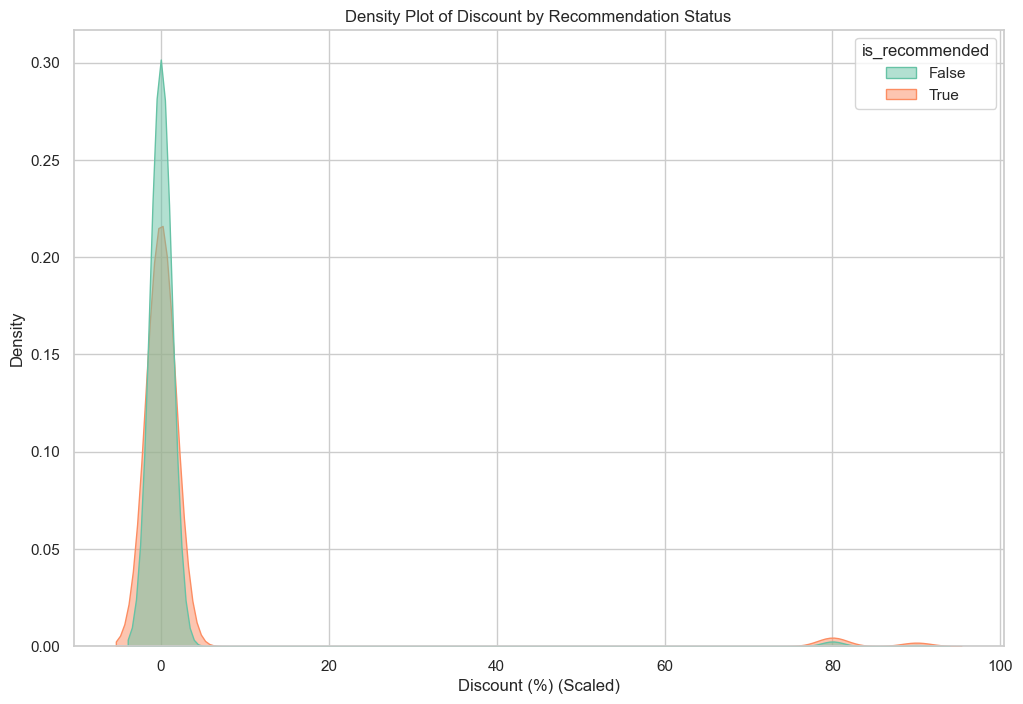

In [83]:
# Density plot of discount by recommendation status
sns.kdeplot(data=final_dataset, x='discount', hue='is_recommended', fill=True, common_norm=False, palette='Set2', alpha=0.5)
plt.title('Density Plot of Discount by Recommendation Status')
plt.xlabel('Discount (%) (Scaled)')
plt.ylabel('Density')
plt.show()

The discount density plot shows significant overlap between recommended and non-recommended games, with most discounts clustered near 0%. A minor peak is observed around 80-90% discounts for both categories, suggesting that deep discounts are rare and do not strongly influence recommendations.

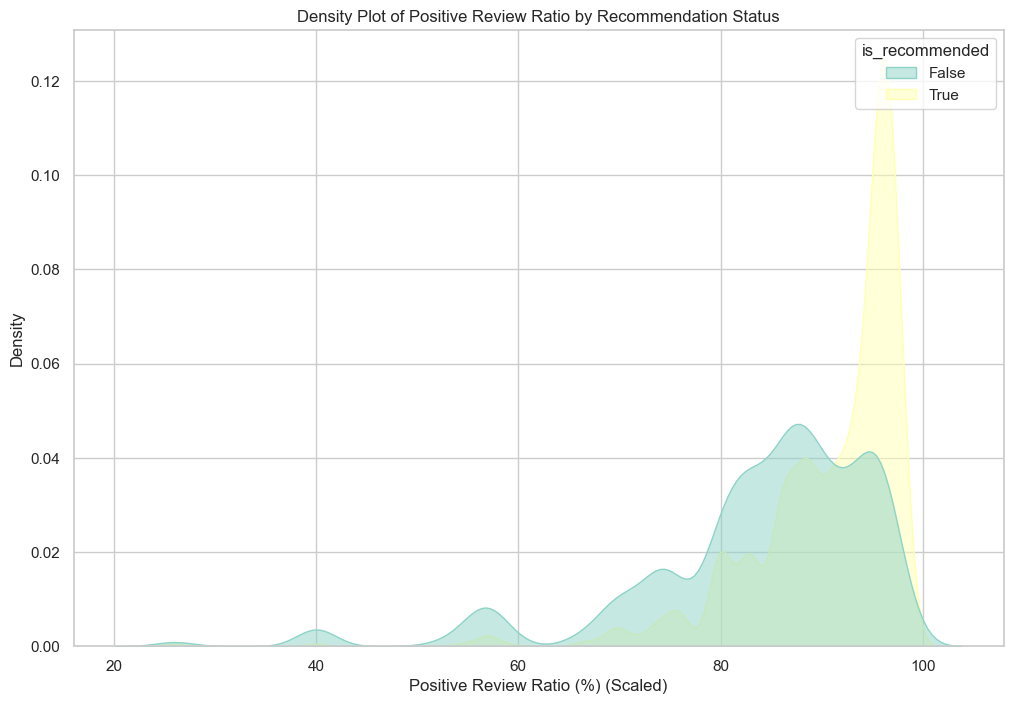

In [84]:
# Density plot of positive_ratio by recommendation status
sns.kdeplot(data=final_dataset, x='positive_ratio', hue='is_recommended', fill=True, common_norm=False, palette='Set3', alpha=0.5)
plt.title('Density Plot of Positive Review Ratio by Recommendation Status')
plt.xlabel('Positive Review Ratio (%) (Scaled)')
plt.ylabel('Density')
plt.show()

This plot highlights a stark contrast between recommended and non-recommended games. Recommended games exhibit a pronounced peak near 100%, whereas non-recommended games display a broader distribution spanning 60-100%. This emphasizes the importance of high positive review ratios in driving recommendations.

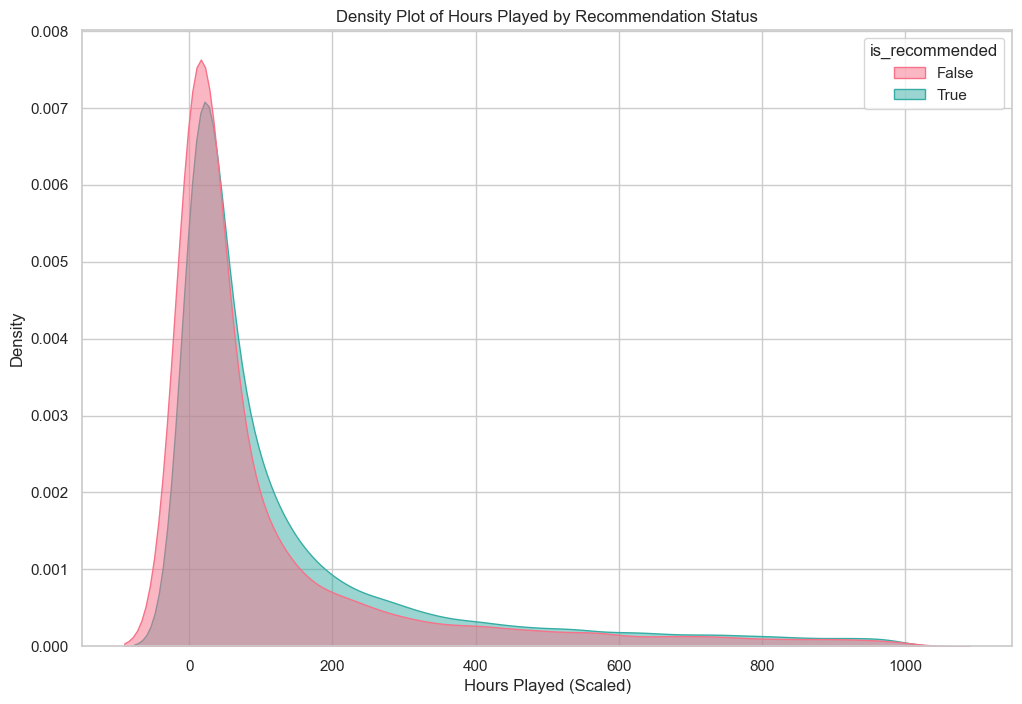

In [85]:
# Density plot of hours played by recommendation status
sns.kdeplot(data=final_dataset, x='hours', hue='is_recommended', fill=True, common_norm=False, palette='husl', alpha=0.5)
plt.title('Density Plot of Hours Played by Recommendation Status')
plt.xlabel('Hours Played (Scaled)')
plt.ylabel('Density')
plt.show()

The density plot for hours played reveals that both recommended and non-recommended games share a right-skewed distribution, with most players logging fewer than 200 hours. However, recommended games have a slightly higher density in the mid-range playtime (100–200 hours), suggesting that games with higher engagement tend to receive more recommendations.

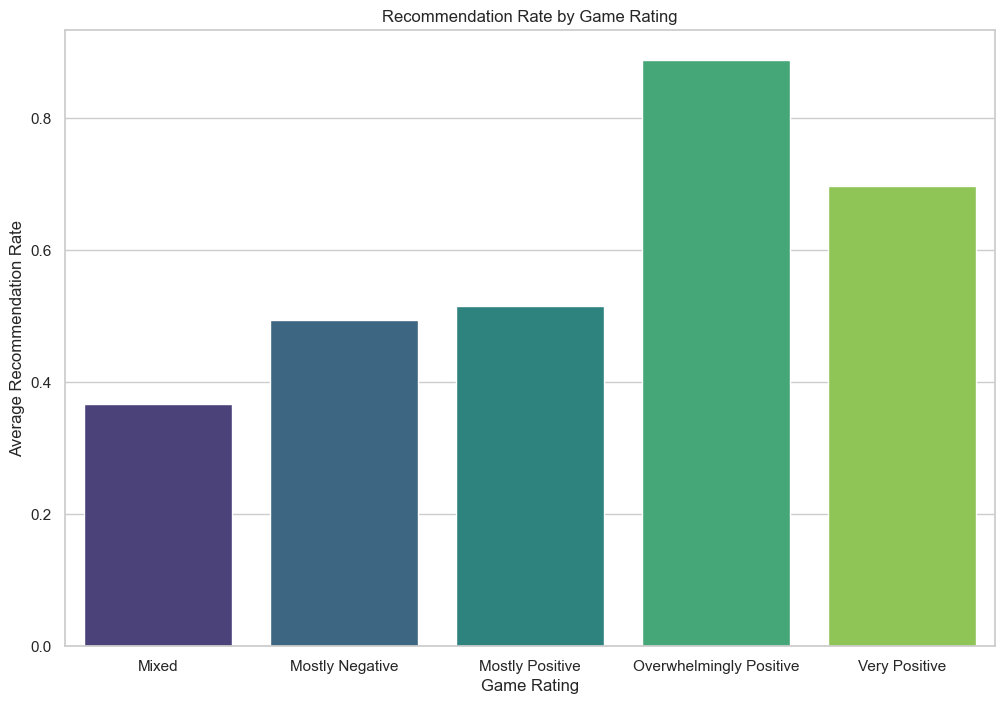

In [86]:
rating_recommendation = final_dataset.groupby('rating')['is_recommended'].mean().reset_index()

# Bar plot of recommendation rates by rating
sns.barplot(x='rating', y='is_recommended', data=rating_recommendation, palette='viridis')
plt.title('Recommendation Rate by Game Rating')
plt.xlabel('Game Rating')
plt.ylabel('Average Recommendation Rate')
plt.show()

The bar chart illustrates a strong positive correlation between game ratings and recommendation rates. “Overwhelmingly Positive” games exhibit the highest average recommendation rate (~85%), followed by “Very Positive” ratings (~70%). Interestingly, “Mostly Negative” games (~45%) outperform “Mixed” games (~35%) in recommendation rate, suggesting that user recommendations are influenced by more than just overall sentiment.


## Conclusion

Final Conclusion and Insights

The analysis of the provided graphs highlights several critical factors influencing game recommendations on Steam. Here are the key takeaways:

1.	Positive Review Ratios Drive Recommendations:
A high positive review ratio emerges as the most significant determinant of recommendations. Games with overwhelmingly positive feedback (85%-100%) are much more likely to be endorsed by users. Conversely, games with lower positive review ratios exhibit more variability in recommendation likelihood.

2.	Moderate Pricing is Favorable:
Games priced at $20 consistently show higher recommendation rates, suggesting that users favor moderately priced games. While free games and those priced at $40 or $60 are also popular, the concentration of recommendations around the $20 price point underscores its appeal. However, price alone is not the sole determinant, as both recommended and non-recommended games share overlapping price distributions.

3.	Discounts Have Limited Influence:
The majority of games, regardless of recommendation status, have little to no discount, with a few exceptions reaching 80-90%. This indicates that while discounts might incentivize initial purchases, they do not strongly affect user recommendations.

4.	Higher Engagement Correlates with Recommendations:
Games with longer playtime, particularly in the mid-range of 100-200 hours, are more likely to be recommended. This suggests that sustained engagement is a key driver of positive user experiences and endorsements.

5.	Game Ratings Reflect User Preferences:
Game ratings strongly correlate with recommendations. Titles rated “Overwhelmingly Positive” and “Very Positive” receive the highest recommendation rates, while “Mostly Negative” games outperform “Mixed” ratings. This indicates that even lower-rated games can achieve notable recommendations, highlighting varied user preferences and the influence of other factors beyond overall sentiment.

6.	Interdependencies Between Features
The correlation matrix suggests that helpfulness and humor in reviews are interrelated, while positive reviews moderately correlate with recommendations. The relatively weak correlations among other variables reduce multicollinearity concerns, providing a solid foundation for predictive modeling.



## Modeling & Interpretations

In [87]:
import pandas as pd
import numpy as np

final_dataset = pd.read_csv('data/final_dataset.csv', parse_dates=['date_release'])

print("First 5 rows of the dataset:")
print(final_dataset.head())

# Check for missing values
print("\nMissing Values in Each Column:")
print(final_dataset.isnull().sum())

First 5 rows of the dataset:
   app_id  helpful  funny        date  is_recommended  hours   user_id  \
0  221100        7      0  2017-04-17           False    0.3   8088013   
1  601150       65      9  2019-03-08           False    7.7  10613654   
2    8870        7      2  2020-08-24           False   19.4   2289902   
3  221100       11      2  2016-01-23           False    0.6  13028588   
4  306130        4      2  2016-11-22           False    0.7  11834711   

   review_id  price_final  discount  positive_ratio date_release  \
0   16122366         45.0       0.0              74   2018-12-13   
1   33478462         30.0       0.0              95   2019-03-07   
2   25669626         30.0       0.0              93   2013-03-25   
3   33538746         45.0       0.0              74   2018-12-13   
4    5349334         20.0       0.0              83   2017-05-22   

                    rating  
0          Mostly Positive  
1  Overwhelmingly Positive  
2            Very Positive  
3

In [88]:
# Select relevant features
features = ['helpful', 'funny', 'hours', 'price_final', 'discount', 'positive_ratio', 'rating']
target = 'is_recommended'

X = final_dataset[features]
y = final_dataset[target]

print("\nSelected Features:")
print(X.head())
print("\nTarget Variable:")
print(y.head())


Selected Features:
   helpful  funny  hours  price_final  discount  positive_ratio  \
0        7      0    0.3         45.0       0.0              74   
1       65      9    7.7         30.0       0.0              95   
2        7      2   19.4         30.0       0.0              93   
3       11      2    0.6         45.0       0.0              74   
4        4      2    0.7         20.0       0.0              83   

                    rating  
0          Mostly Positive  
1  Overwhelmingly Positive  
2            Very Positive  
3          Mostly Positive  
4            Very Positive  

Target Variable:
0    False
1    False
2    False
3    False
4    False
Name: is_recommended, dtype: bool


In [89]:
from sklearn.preprocessing import OneHotEncoder

print("\nUnique Ratings:", X['rating'].unique())

X_encoded = pd.get_dummies(X, columns=['rating'], drop_first=True)

print("\nFeatures after One-Hot Encoding:")
print(X_encoded.head())


Unique Ratings: ['Mostly Positive' 'Overwhelmingly Positive' 'Very Positive' 'Mixed'
 'Mostly Negative']

Features after One-Hot Encoding:
   helpful  funny  hours  price_final  discount  positive_ratio  \
0        7      0    0.3         45.0       0.0              74   
1       65      9    7.7         30.0       0.0              95   
2        7      2   19.4         30.0       0.0              93   
3       11      2    0.6         45.0       0.0              74   
4        4      2    0.7         20.0       0.0              83   

   rating_Mostly Negative  rating_Mostly Positive  \
0                       0                       1   
1                       0                       0   
2                       0                       0   
3                       0                       1   
4                       0                       0   

   rating_Overwhelmingly Positive  rating_Very Positive  
0                               0                     0  
1                     

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (28356, 10)
Testing Set Shape: (7089, 10)


In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nScaled Training Features:")
print(X_train_scaled.head())


Scaled Training Features:
        helpful     funny     hours  price_final  discount  positive_ratio  \
26139 -0.176333 -0.101525 -0.296087    -0.144343 -0.153903        0.430682   
11568 -0.158976 -0.129847  0.021009     0.977995 -0.153903        0.744182   
5852   0.922932  0.040084 -0.665266     2.099772 -0.153903       -0.927820   
24172 -0.205261 -0.129847 -0.561099    -0.144343 -0.153903        0.639682   
21710 -0.187904 -0.129847  1.575850    -0.144343 -0.153903       -0.614320   

       rating_Mostly Negative  rating_Mostly Positive  \
26139               -0.045662               -0.271823   
11568               -0.045662               -0.271823   
5852                -0.045662               -0.271823   
24172               -0.045662               -0.271823   
21710               -0.045662               -0.271823   

       rating_Overwhelmingly Positive  rating_Very Positive  
26139                       -0.777367              0.964449  
11568                        1.286393

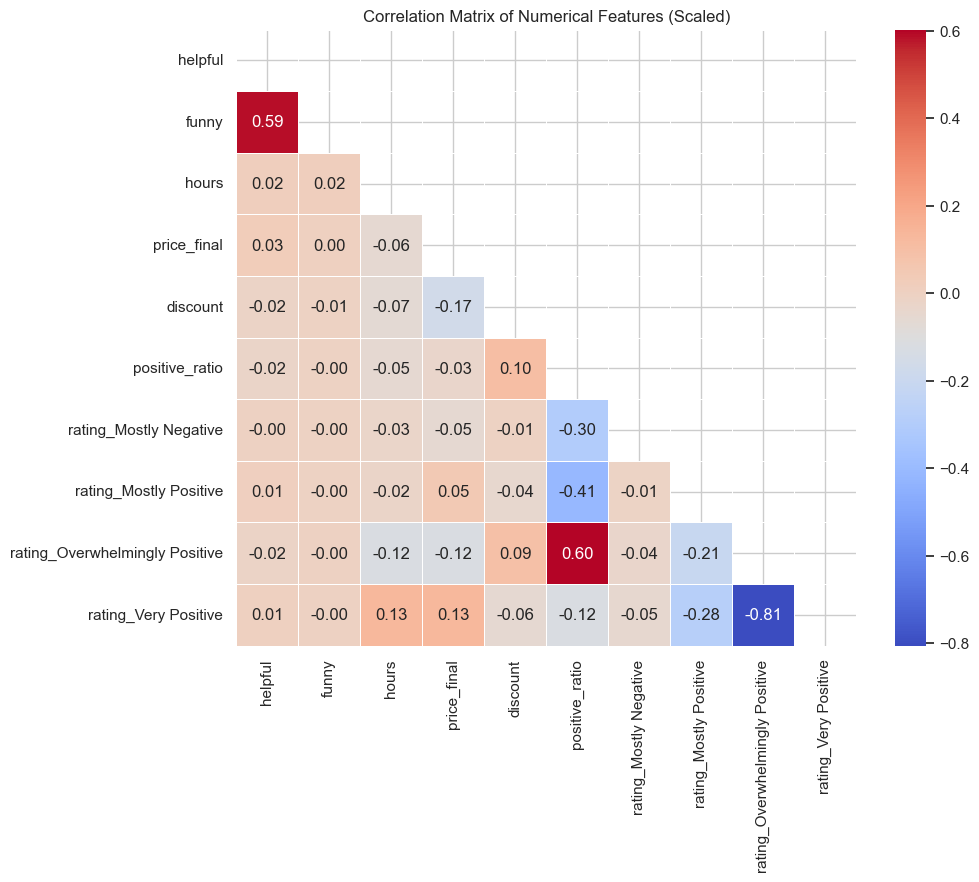


Highly Correlated Feature Pairs:
[]


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train_scaled.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

# heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features (Scaled)')
plt.show()

# identify highly correlated features
threshold = 0.7
high_corr = np.where(corr_matrix > threshold)
high_corr = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr) if x != y and x < y]

print("\nHighly Correlated Feature Pairs:")
print(high_corr)

In [95]:
X_train_final = X_train_scaled.drop(['discount'], axis=1)
X_test_final = X_test_scaled.drop(['discount'], axis=1)

print("\nFeatures after Removing 'discount':")
print(X_train_final.head())


Features after Removing 'discount':
        helpful     funny     hours  price_final  positive_ratio  \
26139 -0.176333 -0.101525 -0.296087    -0.144343        0.430682   
11568 -0.158976 -0.129847  0.021009     0.977995        0.744182   
5852   0.922932  0.040084 -0.665266     2.099772       -0.927820   
24172 -0.205261 -0.129847 -0.561099    -0.144343        0.639682   
21710 -0.187904 -0.129847  1.575850    -0.144343       -0.614320   

       rating_Mostly Negative  rating_Mostly Positive  \
26139               -0.045662               -0.271823   
11568               -0.045662               -0.271823   
5852                -0.045662               -0.271823   
24172               -0.045662               -0.271823   
21710               -0.045662               -0.271823   

       rating_Overwhelmingly Positive  rating_Very Positive  
26139                       -0.777367              0.964449  
11568                        1.286393             -1.036862  
5852                     

***Logistic regression***

In [96]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, max_iter=1000)

log_reg.fit(X_train_final, y_train)

print("\nLogistic Regression Model Trained.")


Logistic Regression Model Trained.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

rf_clf.fit(X_train_final, y_train)

print("\nRandom Forest Classifier Model Trained.")


Random Forest Classifier Model Trained.


In [98]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42, n_estimators=100)

gb_clf.fit(X_train_final, y_train)

print("\nGradient Boosting Classifier Model Trained.")


Gradient Boosting Classifier Model Trained.


In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



--- Logistic Regression ---
Accuracy: 0.7651
Precision: 0.7714
Recall: 0.9731
F1-Score: 0.8606
ROC-AUC: 0.7361

Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.16      0.25      1807
        True       0.77      0.97      0.86      5282

    accuracy                           0.77      7089
   macro avg       0.72      0.57      0.56      7089
weighted avg       0.74      0.77      0.71      7089



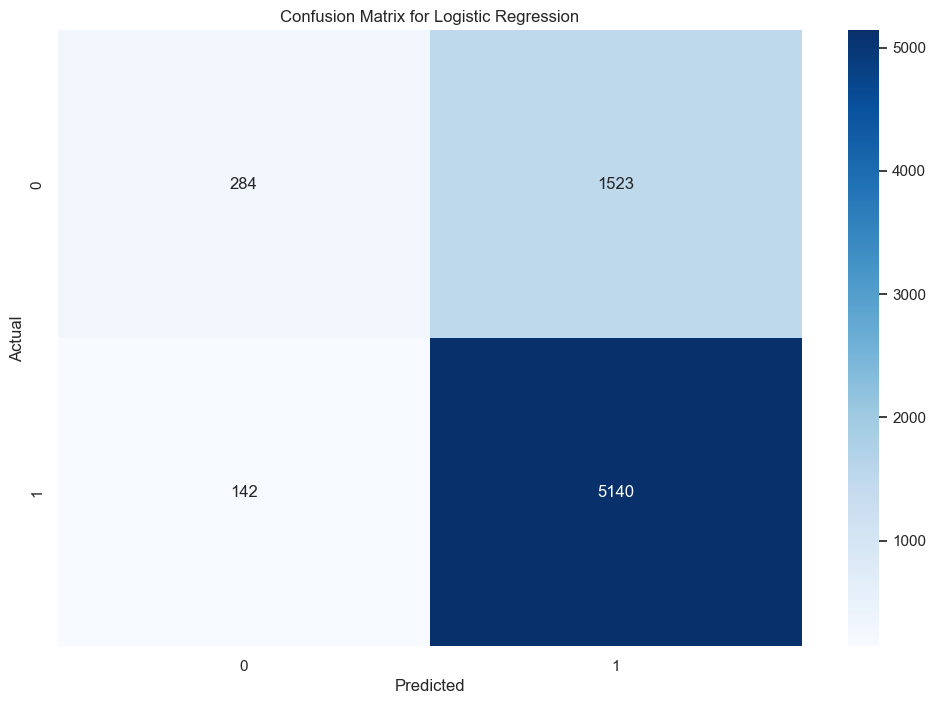

In [100]:
# Evaluate Logistic Regression
evaluate_model(log_reg, X_test_final, y_test, "Logistic Regression")

While the Logistic Regression model demonstrates strong overall accuracy and excels in identifying positive recommendations (high recall), it performs inadequately in detecting non-recommended games, as evidenced by low precision and recall for the False class. This imbalance suggests that the model may be biased towards predicting positive recommendations, potentially overlooking nuances that distinguish non-recommended games.


--- Random Forest Classifier ---
Accuracy: 0.7468
Precision: 0.8067
Recall: 0.8682
F1-Score: 0.8363
ROC-AUC: 0.7267

Classification Report:
              precision    recall  f1-score   support

       False       0.50      0.39      0.44      1807
        True       0.81      0.87      0.84      5282

    accuracy                           0.75      7089
   macro avg       0.66      0.63      0.64      7089
weighted avg       0.73      0.75      0.74      7089



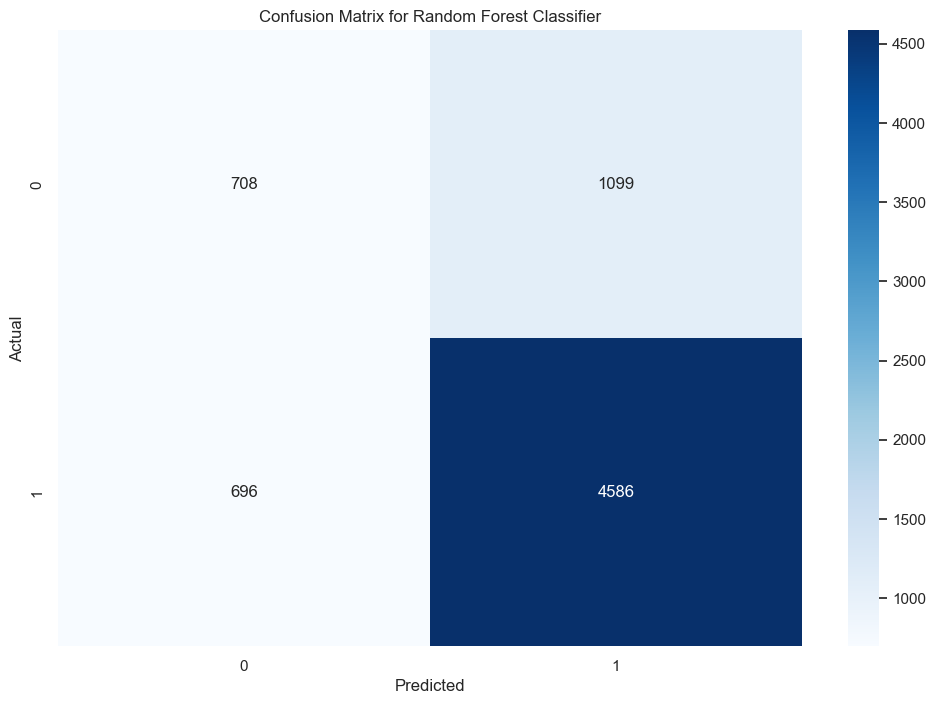

In [101]:
# Evaluate Random Forest
evaluate_model(rf_clf, X_test_final, y_test, "Random Forest Classifier")

The Random Forest Classifier offers a balanced improvement in precision and recall for the True class compared to Logistic Regression, effectively capturing a higher proportion of actual recommendations. However, its ability to accurately identify non-recommended games remains limited, with moderate precision and recall for the False class. The consistency in cross-validation performance underscores its reliability, though enhancements are needed to address class imbalances.


--- Gradient Boosting Classifier ---
Accuracy: 0.7790
Precision: 0.7998
Recall: 0.9381
F1-Score: 0.8635
ROC-AUC: 0.7718

Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.31      0.42      1807
        True       0.80      0.94      0.86      5282

    accuracy                           0.78      7089
   macro avg       0.72      0.63      0.64      7089
weighted avg       0.76      0.78      0.75      7089



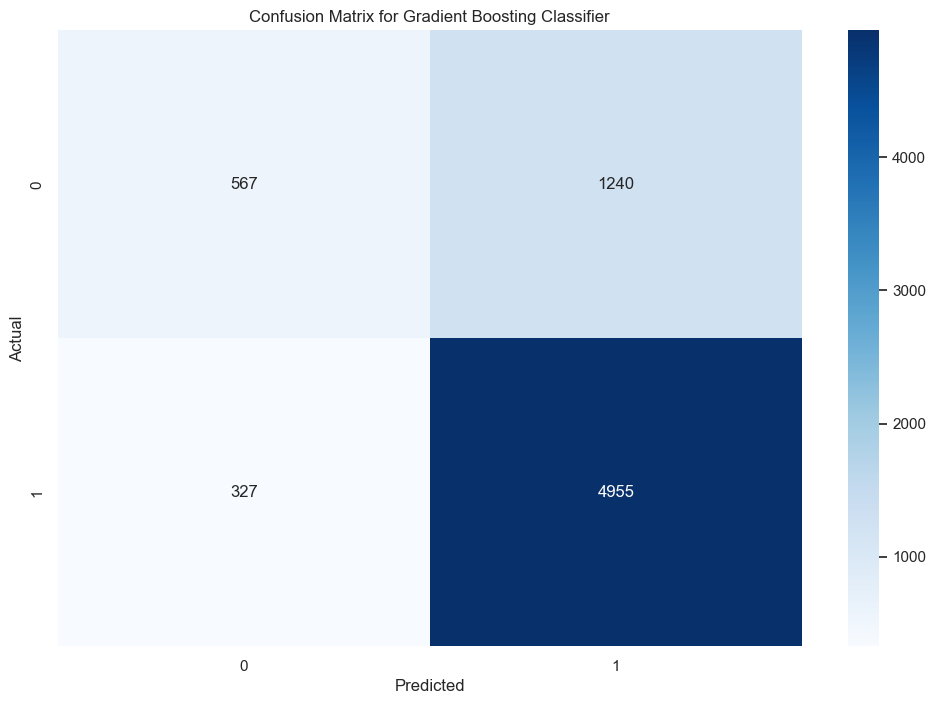

In [102]:
# Evaluate Gradient Boosting
evaluate_model(gb_clf, X_test_final, y_test, "Gradient Boosting Classifier")

The Gradient Boosting Classifier demonstrates superior performance in predicting recommended games, with high precision and recall in the True class. It also shows moderate improvements in precision for the False class, although recall remains a challenge. The higher ROC-AUC score signifies enhanced ability to distinguish between the two classes, making it a promising candidate for further optimization.

In [103]:
from sklearn.model_selection import cross_val_score

models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf
}

# Perform 5-fold cross-validation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_final, y_train, cv=5, scoring='roc_auc')
    print(f"\n{model_name} - Cross-Validated ROC-AUC Scores: {cv_scores}")
    print(f"Mean ROC-AUC: {cv_scores.mean():.4f} | Std: {cv_scores.std():.4f}")


Logistic Regression - Cross-Validated ROC-AUC Scores: [0.74463671 0.71569422 0.71827797 0.7209528  0.73344423]
Mean ROC-AUC: 0.7266 | Std: 0.0109

Random Forest - Cross-Validated ROC-AUC Scores: [0.75384467 0.73616637 0.74182245 0.73056332 0.75112156]
Mean ROC-AUC: 0.7427 | Std: 0.0088

Gradient Boosting - Cross-Validated ROC-AUC Scores: [0.78663933 0.77131986 0.77153249 0.76497983 0.77330313]
Mean ROC-AUC: 0.7736 | Std: 0.0071


In [104]:
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)


In [105]:
rf_grid_search.fit(X_train_final, y_train)

print("\nBest Parameters for Random Forest:")
print(rf_grid_search.best_params_)

print(f"Best ROC-AUC Score: {rf_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.5s
[CV] END m

In [106]:
# update the Random Forest model with best parameters
best_rf_clf = rf_grid_search.best_estimator_

In [107]:
# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

gb_grid_search = GridSearchCV(
    estimator=gb_clf,
    param_grid=gb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

gb_grid_search.fit(X_train_final, y_train)

print("\nBest Parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

print(f"Best ROC-AUC Score: {gb_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.0

In [108]:
# Update the Gradient Boosting model with best parameters
best_gb_clf = gb_grid_search.best_estimator_


--- Tuned Random Forest Classifier ---
Accuracy: 0.7811
Precision: 0.7996
Recall: 0.9424
F1-Score: 0.8651
ROC-AUC: 0.7767

Classification Report:
              precision    recall  f1-score   support

       False       0.65      0.31      0.42      1807
        True       0.80      0.94      0.87      5282

    accuracy                           0.78      7089
   macro avg       0.72      0.63      0.64      7089
weighted avg       0.76      0.78      0.75      7089



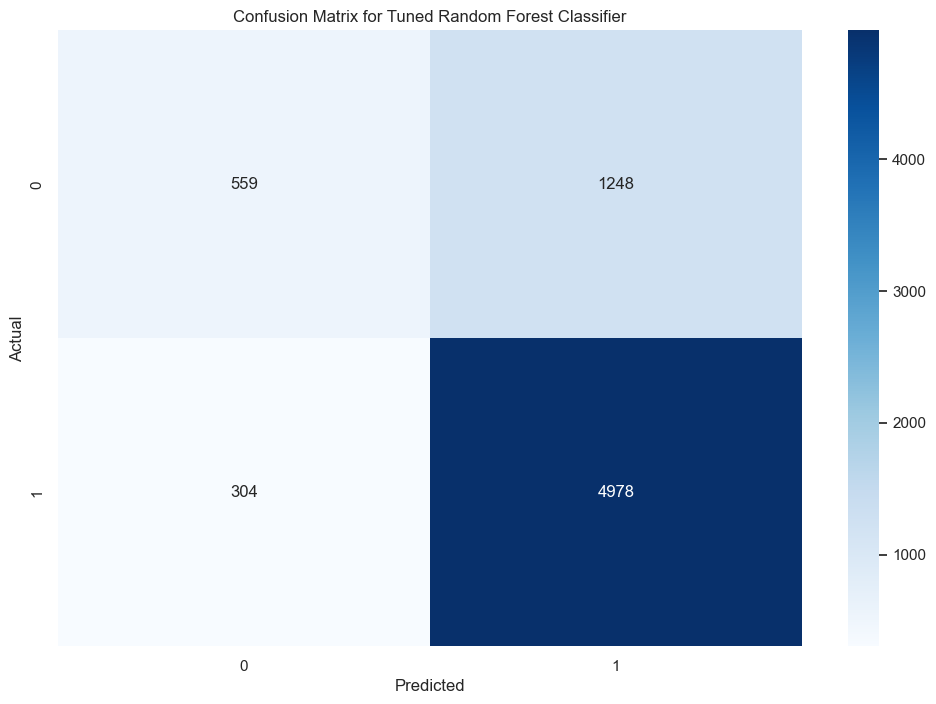

In [110]:
# Evaluate the tuned Random Forest model
evaluate_model(best_rf_clf, X_test_final, y_test, "Tuned Random Forest Classifier")


--- Tuned Gradient Boosting Classifier ---
Accuracy: 0.7797
Precision: 0.7998
Recall: 0.9394
F1-Score: 0.8640
ROC-AUC: 0.7764

Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.31      0.42      1807
        True       0.80      0.94      0.86      5282

    accuracy                           0.78      7089
   macro avg       0.72      0.63      0.64      7089
weighted avg       0.76      0.78      0.75      7089



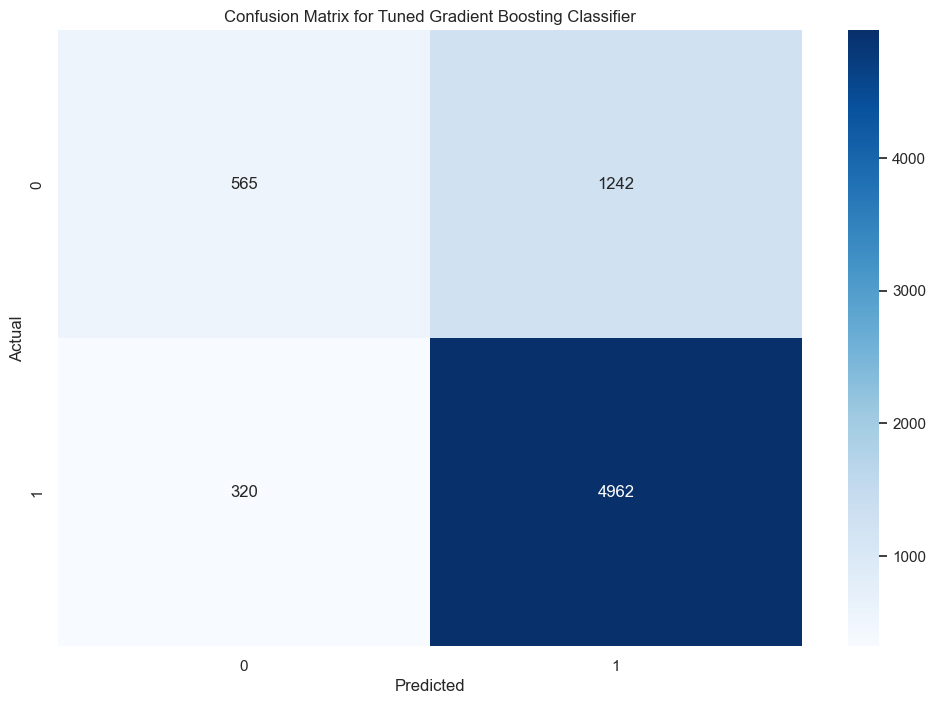

In [111]:

# Evaluate the tuned Gradient Boosting model
evaluate_model(best_gb_clf, X_test_final, y_test, "Tuned Gradient Boosting Classifier")

**Overall Accuracy and ROC-AUC** :
	The Tuned Random Forest and Tuned Gradient Boosting classifiers achieve the highest accuracy (~78%) and ROC-AUC (~0.776), outperforming their untuned counterparts and the Logistic Regression model. This improvement underscores the effectiveness of hyperparameter tuning in enhancing model performance.

**Precision and Recall**:
•All models exhibit high precision (~80%) and recall (~94%) for the True class, indicating strong capabilities in identifying recommended games. However, the False class consistently shows lower precision and recall across all models, revealing a persistent challenge in accurately predicting non-recommended games.

•Tuned Models slightly improve precision for the False class but do not substantially enhance recall, maintaining an F1-Score of 0.42. This suggests that while tuning enhances overall performance, it does not fully address the imbalance in class predictions.

**Cross-Validation Performance**:
The Random Forest and Gradient Boosting models demonstrate consistent ROC-AUC scores across cross-validation folds, with minimal standard deviations, indicating reliable performance. The Logistic Regression model, while consistent, lags slightly behind in ROC-AUC.

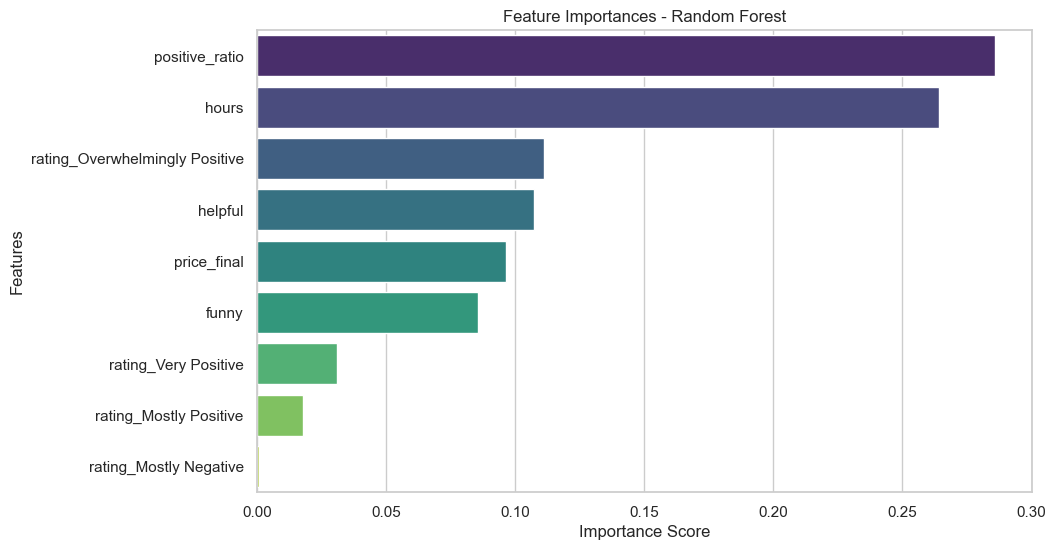

In [112]:
importances = best_rf_clf.feature_importances_
feature_names = X_train_final.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

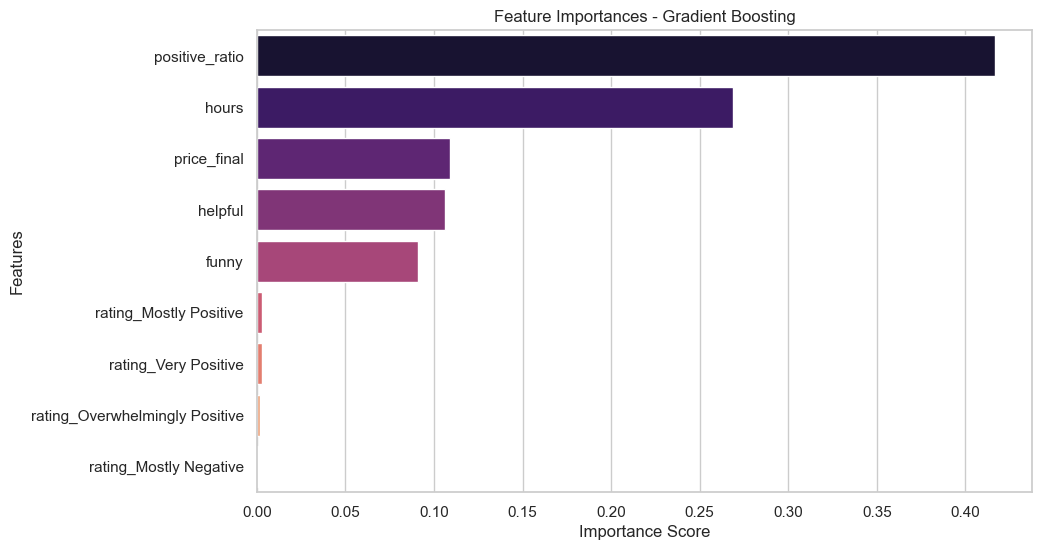

In [113]:
importances_gb = best_gb_clf.feature_importances_
feature_names_gb = X_train_final.columns

feature_importances_gb = pd.DataFrame({
    'Feature': feature_names_gb,
    'Importance': importances_gb
})

feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_gb, palette='magma')
plt.title('Feature Importances - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Positive Review Ratio (positive_ratio) and Hours Played (hours) are consistently the most influential features across both Random Forest and Gradient Boosting models, affirming their critical role in driving recommendations.

Price Final (price_final) and Rating (rating_Overwhelmingly Positive) also contribute significantly, though their impact varies between models. The Random Forest model places more emphasis on the “Overwhelmingly Positive” rating, whereas the Gradient Boosting model undervalues it compared to other rating categories.

Low Importance Features: Features like rating_Mostly Negative have minimal impact, indicating that user sentiments beyond high positive feedback do not strongly influence recommendations.


#### Summary of Findings

The Tuned Random Forest and Tuned Gradient Boosting classifiers emerge as the most effective models for predicting game recommendations on Steam, achieving high accuracy and robust ROC-AUC scores. These models leverage the critical features of positive review ratios and hours played, which are strongly indicative of user endorsements. While both classifiers excel in identifying recommended games, they share a common limitation in accurately predicting non-recommended ones, as evidenced by low precision and recall in the False class.

The Random Forest model slightly edges out Gradient Boosting in ROC-AUC and precision metrics, making it a marginally better choice for this specific prediction task. However, both models provide valuable insights into feature importance, guiding future strategies to enhance user satisfaction and recommendation rates.

## Strategic Implications

- Enhancing Positive Feedback:
Emphasizing and fostering positive user reviews can significantly boost recommendation rates, as demonstrated by the high importance of the positive_ratio feature.

- Sustaining Engagement:
Encouraging longer playtimes through engaging game design can further enhance the likelihood of recommendations, aligning with the strong influence of the hours feature.

- Optimal Pricing Strategies:
Maintaining a moderate pricing tier around $20 appears favorable for user endorsements, though price alone does not dictate recommendations.

- Addressing Class Imbalance:
To improve the model’s ability to predict non-recommended games, strategies such as resampling techniques (e.g., SMOTE), adjusting class weights, or exploring alternative modeling approaches could be considered.


## Next Steps & Discussion

- Feature Engineering:
Develop new features or interactions that may help in better distinguishing non-recommended games, potentially improving recall and precision for the False class.

- Advanced Modeling Techniques:
Experiment with ensemble methods, stacking, or other sophisticated algorithms to enhance predictive performance.

- Model Deployment and Monitoring:
Implement the chosen model in a production environment, ensuring continuous monitoring and periodic retraining to maintain accuracy over time.

By leveraging these insights and refining the modeling approach, developers and marketers can strategically enhance game offerings, optimize pricing, and improve user engagement to maximize recommendation rates on Steam.